In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Import

In [2]:
df = pd.read_csv("data.csv")
df.rename(columns={"stage_id":"measurement", "level_cm":"level [cm]", "voltaje_v":"voltage [V]"}, inplace=True)
df.head()

,measurement,level [cm],sample_no,adc,voltage [V]
0,0,0,1,0,0.1420
1,0,0,2,719,0.7214
2,0,0,3,710,0.7142
3,0,0,4,706,0.7109
4,0,0,5,742,0.7399


In [3]:
df_v_i = pd.read_csv("data_voltage_current.csv")
df_v_i

,I_min,I_max,V_min
0,4.74,4.83,1.4
1,4.71,4.83,NaN
2,4.69,4.82,NaN
3,4.72,4.82,NaN
4,4.72,4.83,NaN
5,4.70,4.82,NaN
6,4.69,4.83,NaN
7,4.65,4.82,NaN
8,4.70,4.83,NaN
9,4.71,4.83,NaN


# EDA

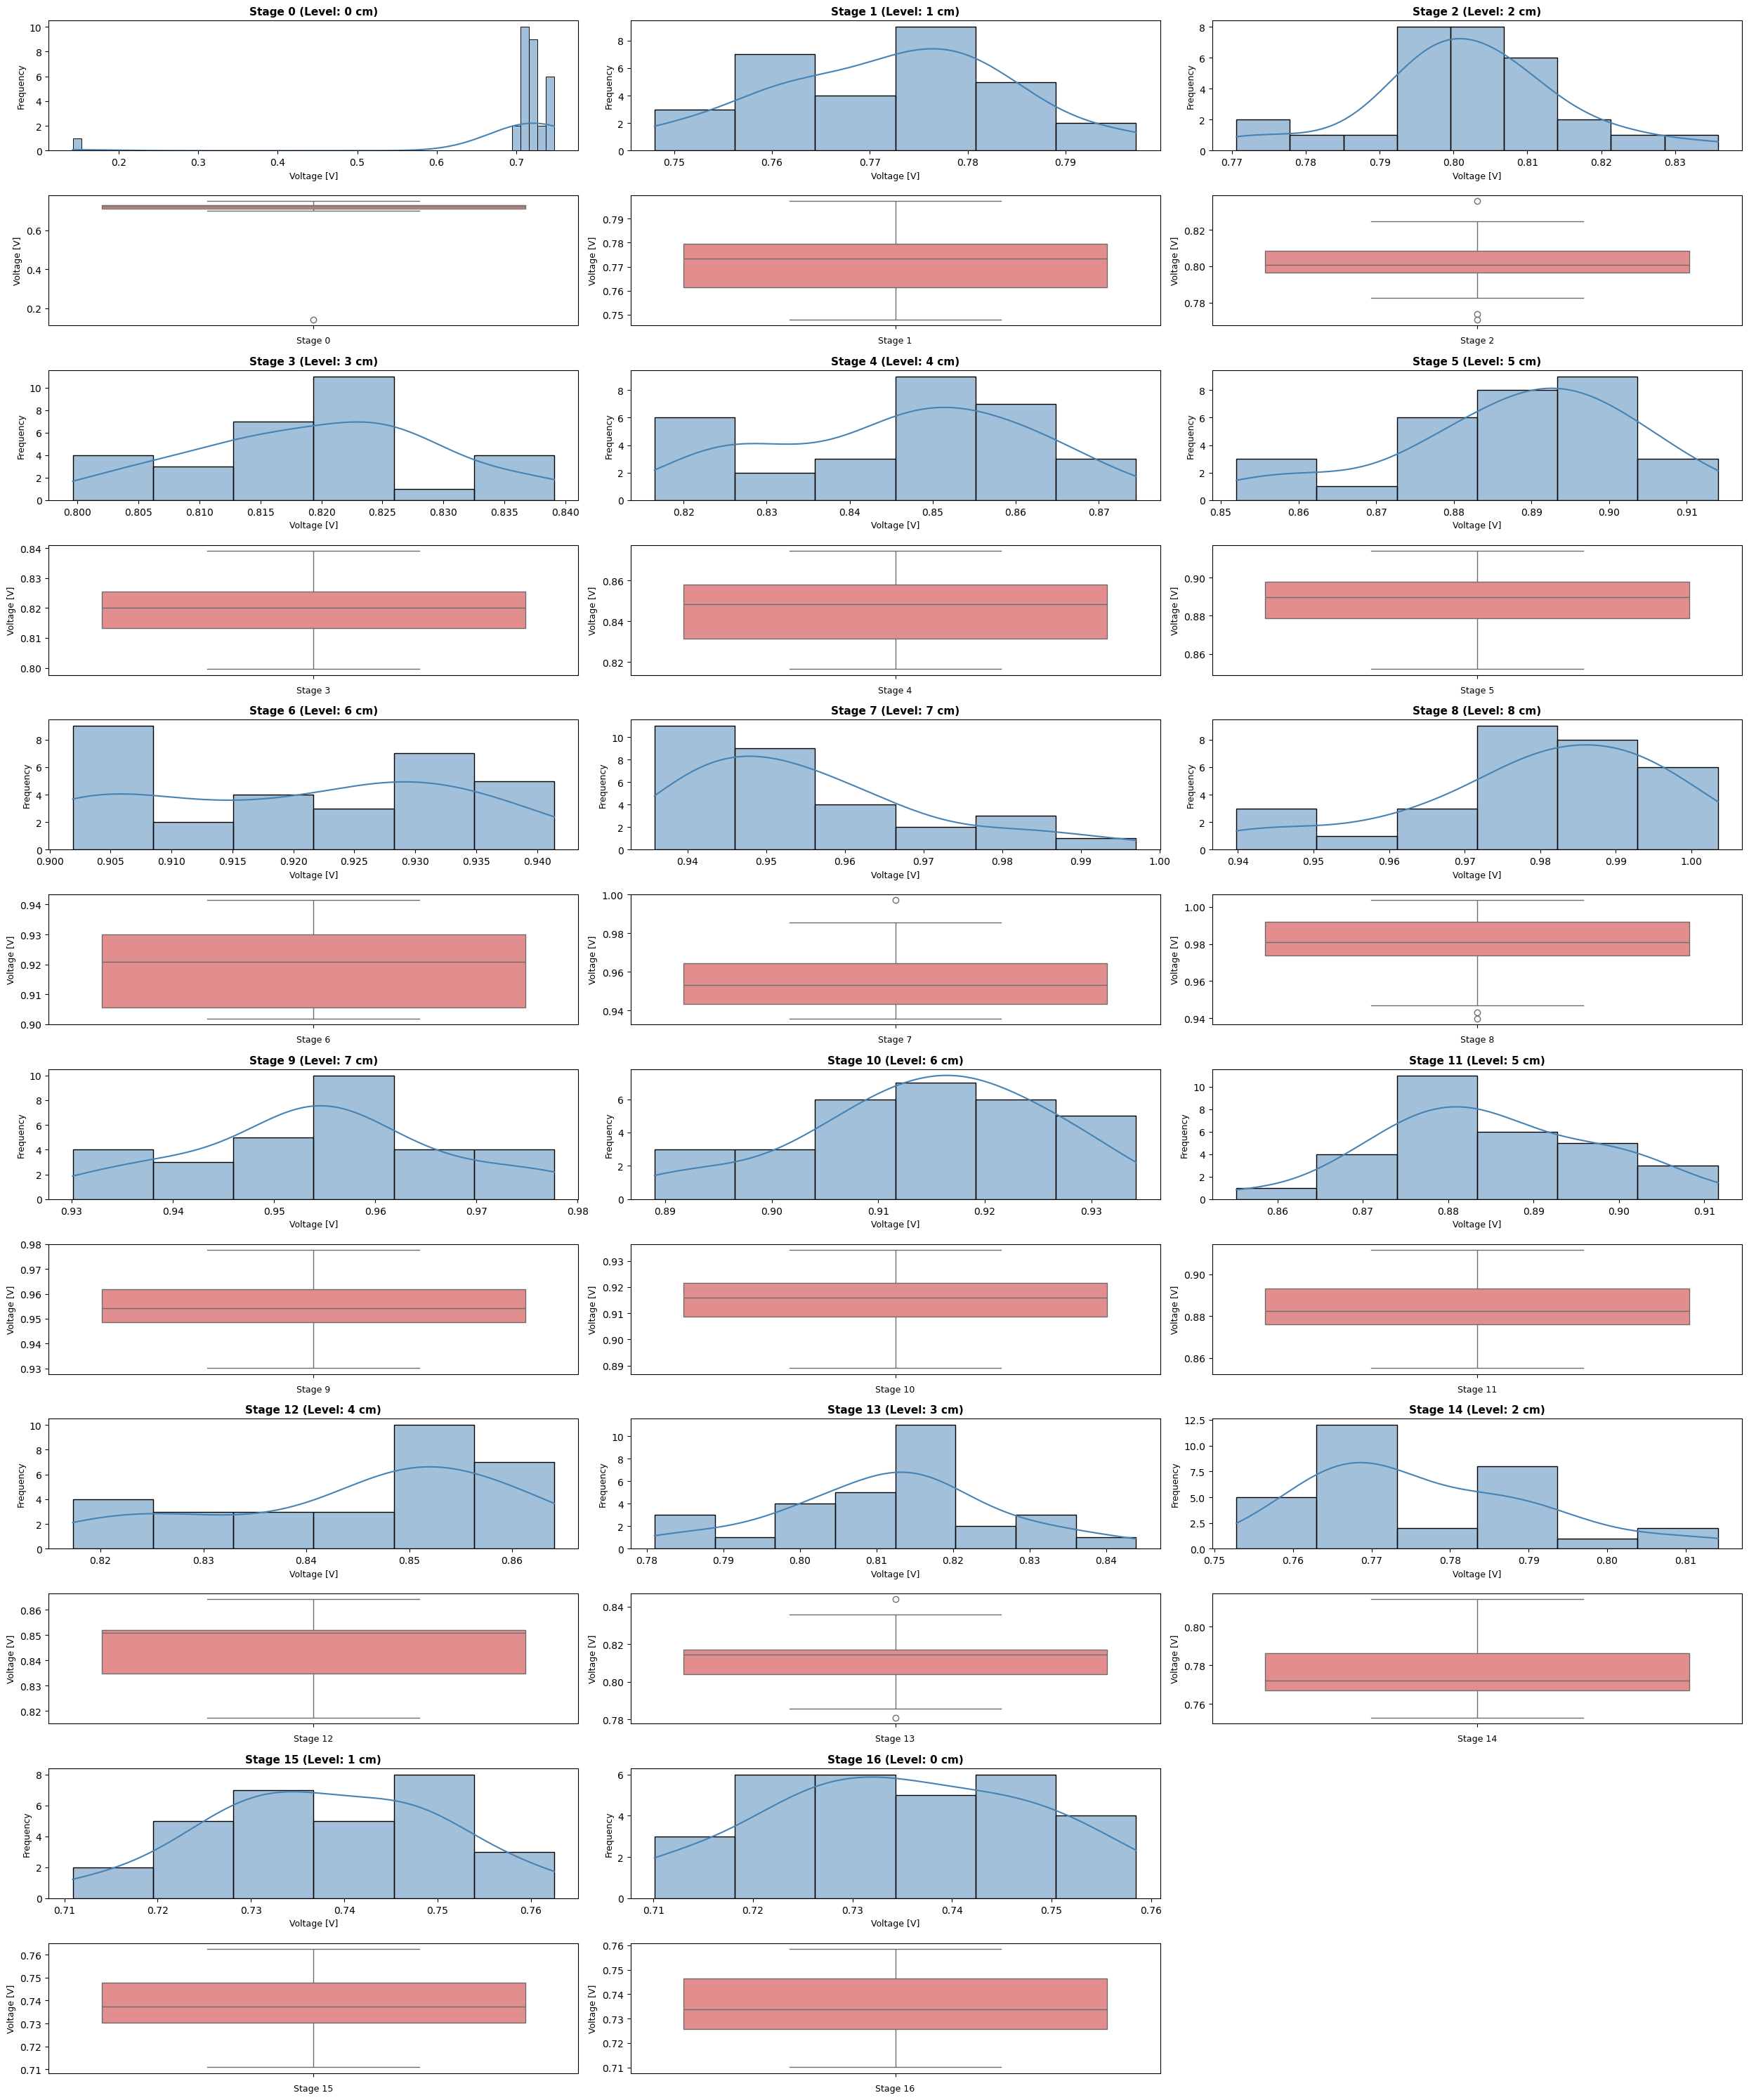

In [4]:
n_measurements = df["measurement"].nunique()
n_cols = 3
n_rows = ((n_measurements + n_cols - 1) // n_cols) * 2  # 2 rows per measurement group (hist + box)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(25, 30))#figsize=(5*n_cols, 4*n_rows))

# Ensure axes is 2D even if only one row
if n_rows == 1:
    axes = axes.reshape(1, -1)
if n_cols == 1:
    axes = axes.reshape(-1, 1)

for i in range(n_measurements):
    col = i % n_cols  # column position (0, 1, or 2)
    row_group = (i // n_cols) * 2  # which pair of rows (0-1, 2-3, 4-5, etc.)
    
    voltage = df[df["measurement"] == i]["voltage [V]"]
    level = df[df["measurement"] == i]["level [cm]"].iloc[0]
    
    # Histogram with KDE in the upper row of this group
    sns.histplot(voltage, kde=True, ax=axes[row_group, col], color="steelblue")
    axes[row_group, col].set_title(f"Stage {i} (Level: {level} cm)", fontsize=11, fontweight="bold")
    axes[row_group, col].set_xlabel("Voltage [V]", fontsize=9)
    axes[row_group, col].set_ylabel("Frequency", fontsize=9)
    
    # Boxplot in the lower row of this group
    sns.boxplot(y=voltage, ax=axes[row_group + 1, col], color="lightcoral")
    axes[row_group + 1, col].set_ylabel("Voltage [V]", fontsize=9)
    axes[row_group + 1, col].set_xlabel(f"Stage {i}", fontsize=9)

# Hide unused subplots
for i in range(n_measurements, n_rows * n_cols // 2):
    col = i % n_cols
    row_group = (i // n_cols) * 2
    if row_group < n_rows:
        axes[row_group, col].set_visible(False)
        axes[row_group + 1, col].set_visible(False)

plt.tight_layout()
plt.show()

With the previous analysis it is clear that a measurement error took place during the very first measurement stage. It is up to the data scientist/analyst to either keep the outlier and proceed with the analysis, or to handle it first by applying any of the many exiting techniques to handle outliers. In this case, the outlier is replaced with the mean of the values.

In [5]:
df.loc[0,"voltage [V]"] = df[df["measurement"] == 0]["voltage [V]"].mean()

Now, since 30 samples were recorded for each reference level point (from 0cm up to 8cm, in steps of 1cm), the dataframes are manipulated to extract valuable information from them.

In [6]:
aggregated_values_df = df.groupby(by="measurement").agg(func="mean",)[["level [cm]", "voltage [V]"]]
aggregated_values_df

,level [cm],voltage [V]
measurement,,
0,0.0,0.720956
1,1.0,0.772153
2,2.0,0.801867
3,3.0,0.819847
4,4.0,0.845900
5,5.0,0.887933
6,6.0,0.920103
7,7.0,0.955213
8,8.0,0.979700


In [7]:
#Hysteresis Dataframe
asc = aggregated_values_df.loc[0:7, "voltage [V]"].reset_index(drop=True)
desc = aggregated_values_df.loc[9::, "voltage [V]"][::-1].reset_index(drop=True)
asc_des_df = pd.concat([asc, desc], axis="columns", ignore_index=True)
asc_des_df.columns = ["ascending", "descending"]
asc_des_df

,ascending,descending
0,0.720956,0.734917
1,0.772153,0.737957
2,0.801867,0.776780
3,0.819847,0.811780
4,0.845900,0.845123
5,0.887933,0.884620
6,0.920103,0.914417
7,0.955213,0.954497


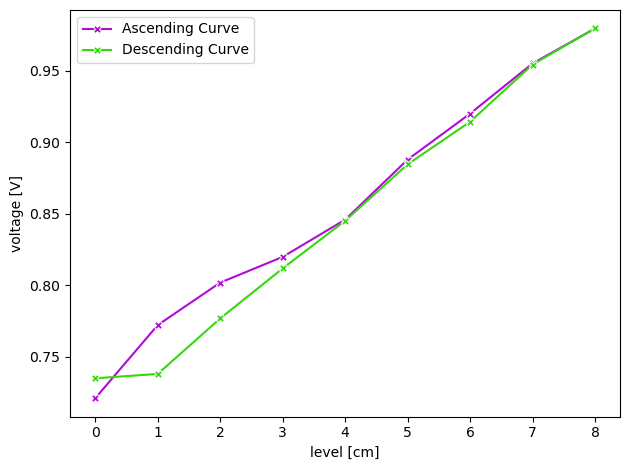

In [8]:
def print_measurement_curve():
    sns.lineplot(x=aggregated_values_df["level [cm]"].head(9), y=aggregated_values_df["voltage [V]"].head(9), marker='X', color="#B00BD9", label="Ascending Curve")
    sns.lineplot(x=aggregated_values_df["level [cm]"].tail(9), y=aggregated_values_df["voltage [V]"].tail(9), marker='X', color="#34D90B", label="Descending Curve")
print_measurement_curve()
plt.legend()
plt.tight_layout()
plt.show()

# Linear Regression

In [9]:
from sklearn.linear_model import LinearRegression

X_data = aggregated_values_df["level [cm]"].to_numpy().reshape(-1,1)
y_data = aggregated_values_df["voltage [V]"].to_numpy().reshape(-1,1)

reg = LinearRegression().fit(X=X_data, y=y_data)

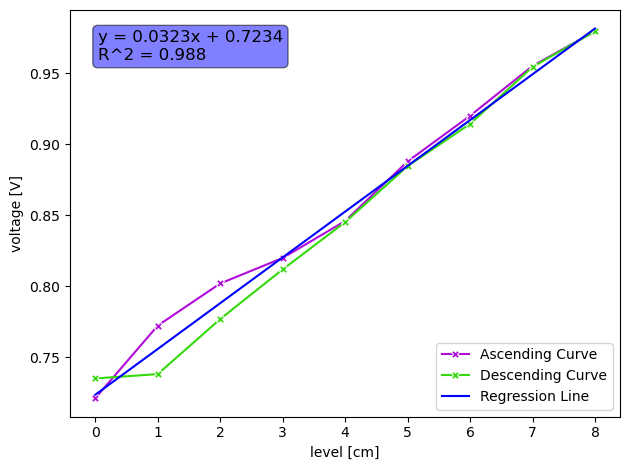

In [10]:
slope = reg.coef_[0,0]
intercept = reg.intercept_[0]
r_2 = reg.score(X=X_data, y=y_data)
equation = f'y = {slope:.4f}x + {intercept:.4f}\nR^2 = {r_2:.3f}'

x_reg = np.linspace(start=0, stop=8, num=100)
y_reg = slope*x_reg + intercept

print_measurement_curve()
sns.lineplot(x=x_reg, y=y_reg, label="Regression Line", color="blue")
plt.text(0.05, 0.95, equation, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='blue', alpha=0.5))
plt.legend()
plt.tight_layout()
plt.show()
plt.show()

# Sensor's Electric Specifications

In [11]:
v_max_lm331 = 40
v_max_lm741 = 22

min_input_voltage = df_v_i.loc[0,"V_min"]
typical_input_voltage = 9
max_input_voltage = np.min([v_max_lm331,v_max_lm741])

min_output_voltage = df["voltage [V]"].min()
max_output_voltage = df["voltage [V]"].max()

output_impedance = 100.4

min_current = df_v_i["I_min"].mean()
max_current = df_v_i["I_max"].mean()

print(f"Tensión mínima de alimentación: {min_input_voltage:.3f} V")
print(f"Tensión típica de alimentación: {typical_input_voltage:.3f} V")
print(f"Tensión máxima de alimentación: {max_input_voltage:.3f} V")

print(f"Tensión mínima de salida: {min_output_voltage:.3f} V")
print(f"Tensión máxima de salida: {max_output_voltage:.3f} V")

print(f"Impedancia de salida: {output_impedance} KOhm")

print(f"Consumo de corriente mínimo: {min_current:.3f} mA")
print(f"Consumo de corriente máximo: {max_current:.3f} mA")

Tensión mínima de alimentación: 1.400 V
Tensión típica de alimentación: 9.000 V
Tensión máxima de alimentación: 22.000 V
Tensión mínima de salida: 0.701 V
Tensión máxima de salida: 1.004 V
Impedancia de salida: 100.4 KOhm
Consumo de corriente mínimo: 4.703 mA
Consumo de corriente máximo: 4.826 mA


# Sensor's Static Characteristics

As follows, the criteria used to calculate some of the static characteristics are listed:

- Precision: Maximum standard deviation among the different measure processes which took place.
- Accuracy: Maximum distance between the measured points and the desired behavior. The desired behavior is defined as the line that best fits to the points, but without the observed offset.
- Linearity: Coefficient of determination of the best fitting line.
- Sensitivity: Slope of the best fitting line.

In [12]:
precision = df.groupby(by="measurement")["voltage [V]"].agg("std").max()
accuracy = intercept
linearity = r_2
sensitivity = slope
hysteresis = max(abs(asc_des_df["ascending"] - asc_des_df["descending"]))
input_range = (float(df["level [cm]"].min()), float(df["level [cm]"].max()))
output_range = (float(df["voltage [V]"].min()), float(df["voltage [V]"].max()))
fso = output_range[1] - output_range[0]


print(f"Rango de entrada: {input_range} cm")
print(f"Rango de salida: {output_range} V")
print(f"FSO: {fso:.3f} V")
print(f"Precisión: {precision:.3f}")
print(f"Exactitud: {accuracy:.3f}")
print(f"Linealidad: {linearity:.3f}")
print(f"Sensibilidad: {sensitivity:.3f}")
print(f"Histéresis: {hysteresis:.3f}")

Rango de entrada: (0.0, 8.0) cm
Rango de salida: (0.7005, 1.0035) V
FSO: 0.303 V
Precisión: 0.017
Exactitud: 0.723
Linealidad: 0.988
Sensibilidad: 0.032
Histéresis: 0.034
